In [1]:
import IPython.display as ipd
import numpy as np
import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

In [2]:
# Local imports.
from analysis import single_cycles
from defaults import PITCH_RATE, SAMPLE_RATE
from synthesis import EnvelopeMorpher, StimulusGenerator
from util import midi_to_hz, stft_plot

In [3]:
# Synthesis parameters.
num_partials = 70
midi_pitch = 48
fm_depth = 0.1314
f0 = midi_to_hz(midi_pitch)

In [4]:
# Load env as linear amplitude. (CheapTrick calculates the power spectrum.)
env = single_cycles[0]['env']
env = np.sqrt(env)

In [15]:
# Rock 'n' Roll.

morpher = EnvelopeMorpher(env)
morpher.shuffle_phase(num_shifts=5)

generator = StimulusGenerator(sr=SAMPLE_RATE, pr=PITCH_RATE)
x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

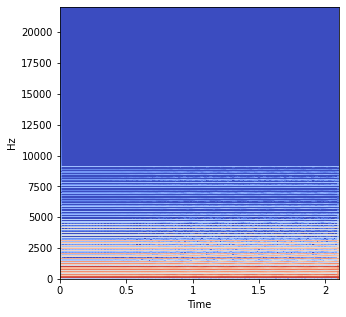

In [16]:
stft_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))